In [180]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, precision_recall_curve, auc
from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from itertools import product


In [181]:
X_train = np.loadtxt("dataset/train/X_train.txt")
y_train = np.loadtxt("dataset/train/y_train.txt", dtype=int) - 1 # Adjust labels to start at 0
X_test = np.loadtxt("dataset/test/X_test.txt")
y_test = np.loadtxt("dataset/test/y_test.txt", dtype=int) - 1 # Adjust labels to start at 0
train_set = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
test_set = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))


In [307]:
def hinge_loss(output, y, model, reg_lambda):
    y_one_hot = torch.zeros_like(output)
    y_one_hot.scatter_(1, y.view(-1, 1), 1) # Convert labels 0-5 to one-hot encoding
    y_one_hot = 2 * y_one_hot - 1  # Convert to {-1, 1} for each class

    loss = torch.sum(torch.clamp(1 - y_one_hot * output, min=0))
    reg_term = reg_lambda * torch.sum(model.linear.weight ** 2)
    return loss + reg_term

def train(train_set, model, criterion, epochs=20, lr=0.01, reg_lambda=0.001, print_epoch=False):
    train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    losses = []
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X, y in train_loader:
            optimizer.zero_grad()
            outputs = model(X)
            if criterion == hinge_loss:
                loss = criterion(outputs, y, model, reg_lambda)
            else:
                loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        losses.append(total_loss)
        if print_epoch:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")
    return losses

def test(test_set, model, criterion, reg_lambda=None, model_name="", show=False):
    test_loader = DataLoader(test_set, batch_size=64, shuffle=False)
    model.eval()
    all_preds = []
    all_probs = []
    y_test = test_set.tensors[1].numpy()
    total_loss = 0
    count = 0
    
    with torch.no_grad():
        for X, y in test_loader:
            outputs = model(X)
            if criterion == hinge_loss:
                loss = criterion(outputs, y, model, reg_lambda)
            else:
                loss = criterion(outputs, y)
            total_loss += loss.item() * X.size(0)
            count += X.size(0)
            preds = torch.argmax(outputs, axis=1).numpy()
            probs = torch.softmax(outputs, axis=1).numpy()
            all_preds.extend(preds)
            all_probs.extend(probs)
    if show:
        print("Accuracy Score:", accuracy_score(y_test, all_preds))
        print(classification_report(y_test, all_preds, digits=4))
        plot_confusion_matrix(y_test, all_preds, model_name)
        plot_AUC(y_test, all_probs, model_name)
    
    return total_loss / count

def plot_loss(losses, model_name="", title="Loss vs Epochs"):
    plt.figure(figsize=(8, 6))
    plt.plot(losses, marker='o', color='b', label="Average Training Loss")
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.title(f"{title} ({model_name})", fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_confusion_matrix(y_test, preds, model_name=""):
    cm = confusion_matrix(y_test, preds)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues')
    plt.title(f"Confusion Matrix ({model_name})")
    plt.show()

def plot_AUC(y_test, probs, model_name=""):
    num_classes = len(np.unique(y_test))
    y_one_hot = np.eye(num_classes)[y_test]
    auc_scores = roc_auc_score(y_one_hot, probs, average=None)
    mean_auc = roc_auc_score(y_one_hot, probs, average='macro')
    print(f"AUC Scores (per class): {auc_scores}")
    print(f"Mean AUC: {mean_auc:.4f}")

    for i in range(y_one_hot.shape[1]):
        precision, recall, _ = precision_recall_curve(y_one_hot[:, i], np.array(probs)[:, i])
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f"Class {i} (AUC={pr_auc:.2f})")
    
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve ({model_name})")
    plt.legend()
    plt.grid()
    plt.show()

def cross_validation_pytorch(model_func, criterion, train_set, lrs, lambdas=None, model_name="", k_folds = 5):
    kf = KFold(n_splits=k_folds, shuffle=True)
    best_loss = float('inf')
    best_hyperparams = {}

    for lr in lrs:
        for reg_lambda in (lambdas if lambdas is not None else [None]):
            hyperparams = {"lr": lr, "reg_lambda": reg_lambda}
            fold_losses = []
            for fold, (train_idx, val_idx) in enumerate(kf.split(train_set)):
                X_train_sub = torch.tensor(X_train[train_idx], dtype=torch.float32)
                y_train_sub = torch.tensor(y_train[train_idx], dtype=torch.long)
                X_val_sub = torch.tensor(X_train[val_idx], dtype=torch.float32)
                y_val_sub = torch.tensor(y_train[val_idx], dtype=torch.long)
                train_sub = TensorDataset(X_train_sub, y_train_sub)
                val_sub = TensorDataset(X_val_sub, y_val_sub)

                model = model_func
                train(train_sub, model, criterion, lr=lr, reg_lambda=reg_lambda)
                val_loss = test(val_sub, model, criterion, reg_lambda=reg_lambda, model_name=model_name)
                fold_losses.append(val_loss)
                # print(f"Fold {fold + 1}/{k_folds}, Hyperparameters: {hyperparams}, Validation Loss: {val_loss:.4f}")

            mean_loss = np.mean(fold_losses)
            print(f"Hyperparameters: {hyperparams}, Mean Validation Loss: {mean_loss:.4f}")

            if mean_loss < best_loss:
                best_loss = mean_loss
                best_hyperparams = {"lr": lr, "reg_lambda": reg_lambda}

    print(f"Best Hyperparameters: {best_hyperparams}, Best Validation Loss: {best_loss:.4f}")

    return best_hyperparams

def train_test_pytorch(train_set, test_set, model, criterion, hyperparams, model_name):
    train_losses = train(train_set, model, criterion, lr=hyperparams["lr"], reg_lambda=hyperparams["reg_lambda"])
    test(test_set, model, criterion, reg_lambda=hyperparams["reg_lambda"], model_name=model_name, show=True)
    plot_loss(train_losses, model_name)

def cross_validation_sklearn(X_train, y_train, model_func, param_grid, k_folds = 5):
    kf = KFold(n_splits=k_folds, shuffle=True)
    
    best_params = None
    best_score = 0
    fold_accuracies = []

    param_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())
    
    for params in param_combinations:
        fold_scores = []
        hyperparams = dict(zip(param_names, params))
        
        for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
            X_train_sub, y_train_sub = X_train[train_idx], y_train[train_idx]
            X_val_sub, y_val_sub = X_train[val_idx], y_train[val_idx]
            
            model = model_func(**hyperparams)
            model.fit(X_train_sub, y_train_sub)
            
            preds = model.predict(X_val_sub)
            accuracy = accuracy_score(y_val_sub, preds)
            fold_scores.append(accuracy)
            # print(f"Fold {fold + 1}/{k_folds}, Hyperparameters: {hyperparams}, Validation Loss: {val_loss:.4f}")
        
        mean_accuracy = np.mean(fold_scores)
        fold_accuracies.append(mean_accuracy)
        print(f"Hyperparameters: {hyperparams}: Mean Validation Accuracy: {mean_accuracy:.4f}")
        
        if mean_accuracy > best_score:
            best_score = mean_accuracy
            best_params = hyperparams
    
    print(f"Best Hyperparameters: {best_params}, Best Validation Accuracy: {best_score:.4f}")

    return best_params

def train_test_sklearn(X_train, y_train, X_test, y_test, model_func, params, model_name):
    model = model_func(**params)
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)
    
    print(f"Accuracy on Test Set:", accuracy_score(y_test, preds))
    print(classification_report(y_test, preds, digits=4))

    plot_confusion_matrix(y_test, preds, model_name)
    plot_AUC(y_test, probs, model_name)


In [309]:
class FCNet(nn.Module):
    def __init__(self, input_size=X_train.shape[1], num_classes=6):
        super(FCNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

lrs = np.linspace(0, 0.1, 5)
FCNet_best_hyperparams = cross_validation_pytorch(FCNet(), nn.CrossEntropyLoss(), train_set, lrs, model_name="FCNet")


Hyperparameters: {'lr': np.float64(0.0), 'reg_lambda': None}, Mean Validation Loss: 1.7995
Hyperparameters: {'lr': np.float64(0.025), 'reg_lambda': None}, Mean Validation Loss: 0.0855
Hyperparameters: {'lr': np.float64(0.05), 'reg_lambda': None}, Mean Validation Loss: 0.0417
Hyperparameters: {'lr': np.float64(0.07500000000000001), 'reg_lambda': None}, Mean Validation Loss: 0.0484
Hyperparameters: {'lr': np.float64(0.1), 'reg_lambda': None}, Mean Validation Loss: 0.1055
Best Hyperparameters: {'lr': np.float64(0.05), 'reg_lambda': None}, Best Validation Loss: 0.0417


Accuracy Score: 0.9545300305395318
              precision    recall  f1-score   support

           0     0.9624    0.9798    0.9710       496
           1     0.9475    0.9575    0.9525       471
           2     0.9681    0.9381    0.9528       420
           3     0.8775    0.9776    0.9249       491
           4     0.9789    0.8741    0.9235       532
           5     1.0000    1.0000    1.0000       537

    accuracy                         0.9545      2947
   macro avg     0.9557    0.9545    0.9541      2947
weighted avg     0.9565    0.9545    0.9545      2947



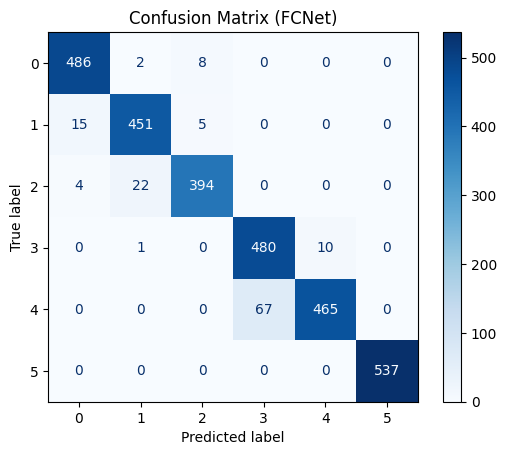

AUC Scores (per class): [0.99924817 0.99818127 0.99855843 0.9958081  0.99630287 1.        ]
Mean AUC: 0.9980


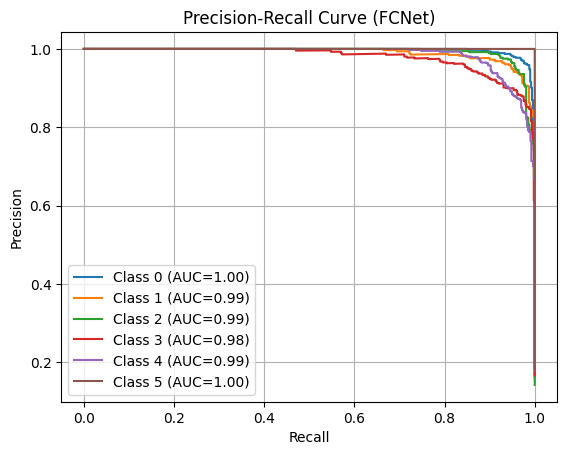

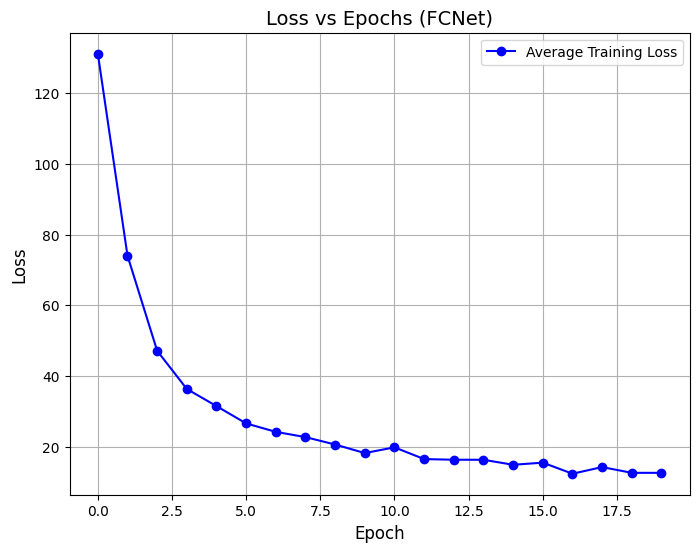

In [311]:
train_test_pytorch(train_set, test_set, FCNet(), nn.CrossEntropyLoss(), FCNet_best_hyperparams, model_name="FCNet")

In [314]:
class SVM(nn.Module):
    def __init__(self, input_size=X_train.shape[1], num_classes=6):
        super(SVM, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        return self.linear(x)

lrs = np.linspace(0, 0.005, 5)
lambdas = np.linspace(0, 0.005, 5)
SVM_best_hyperparams = cross_validation_pytorch(SVM(), hinge_loss, train_set, lrs, lambdas=lambdas, model_name="SVM-PyTorch")


Hyperparameters: {'lr': np.float64(0.0), 'reg_lambda': np.float64(0.0)}, Mean Validation Loss: 409.0932
Hyperparameters: {'lr': np.float64(0.0), 'reg_lambda': np.float64(0.00125)}, Mean Validation Loss: 409.0939
Hyperparameters: {'lr': np.float64(0.0), 'reg_lambda': np.float64(0.0025)}, Mean Validation Loss: 409.0939
Hyperparameters: {'lr': np.float64(0.0), 'reg_lambda': np.float64(0.00375)}, Mean Validation Loss: 409.1011
Hyperparameters: {'lr': np.float64(0.0), 'reg_lambda': np.float64(0.005)}, Mean Validation Loss: 409.1023
Hyperparameters: {'lr': np.float64(0.00125), 'reg_lambda': np.float64(0.0)}, Mean Validation Loss: 11.3445
Hyperparameters: {'lr': np.float64(0.00125), 'reg_lambda': np.float64(0.00125)}, Mean Validation Loss: 5.6784
Hyperparameters: {'lr': np.float64(0.00125), 'reg_lambda': np.float64(0.0025)}, Mean Validation Loss: 5.6682
Hyperparameters: {'lr': np.float64(0.00125), 'reg_lambda': np.float64(0.00375)}, Mean Validation Loss: 7.4040
Hyperparameters: {'lr': np.floa

Accuracy Score: 0.9606379368849678
              precision    recall  f1-score   support

           0     0.9761    0.9879    0.9820       496
           1     0.9784    0.9597    0.9689       471
           2     0.9672    0.9833    0.9752       420
           3     0.9000    0.9348    0.9171       491
           4     0.9505    0.9023    0.9257       532
           5     0.9926    1.0000    0.9963       537

    accuracy                         0.9606      2947
   macro avg     0.9608    0.9613    0.9609      2947
weighted avg     0.9609    0.9606    0.9606      2947



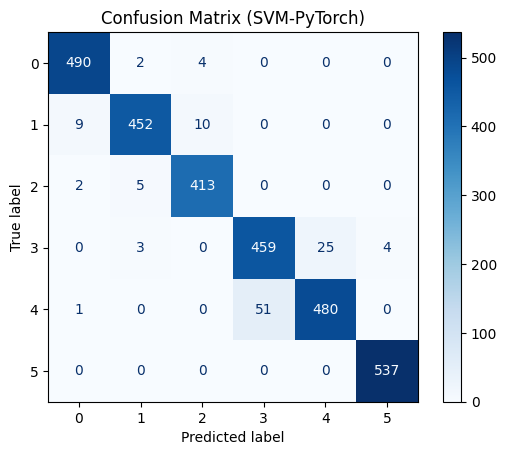

AUC Scores (per class): [0.99970799 0.99887755 0.99960145 0.99389831 0.99505596 1.        ]
Mean AUC: 0.9979


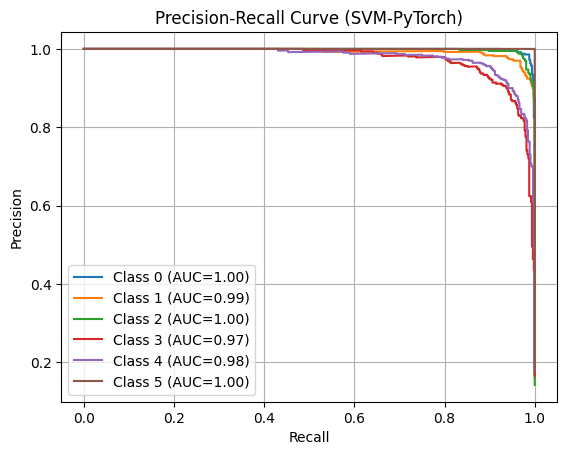

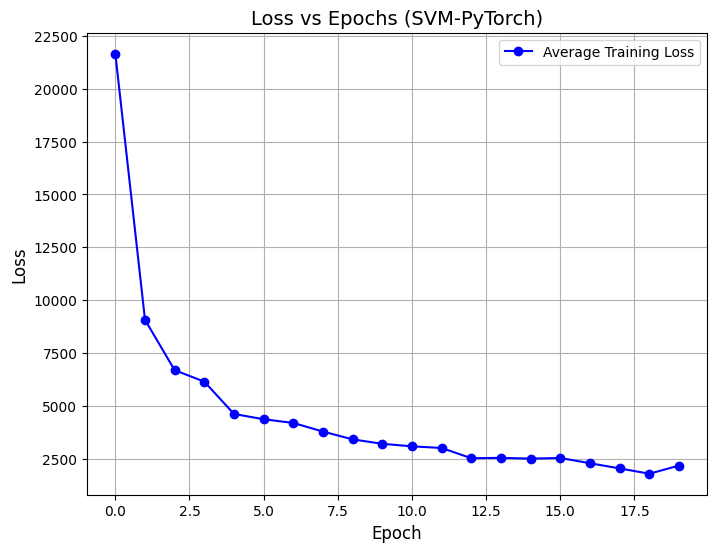

In [316]:
train_test_pytorch(train_set, test_set, SVM(), hinge_loss, SVM_best_hyperparams, model_name="SVM-PyTorch")

In [ ]:
svm_params = {"C": np.logspace(1, 3, 10)}
svm_best_params = cross_validation_sklearn(X_train, y_train, SVC, param_grid=svm_params)

Hyperparameters: {'C': np.float64(10.0)}: Mean Validation Accuracy: 0.9882
Hyperparameters: {'C': np.float64(16.68100537200059)}: Mean Validation Accuracy: 0.9886
Hyperparameters: {'C': np.float64(27.825594022071243)}: Mean Validation Accuracy: 0.9891
Hyperparameters: {'C': np.float64(46.41588833612777)}: Mean Validation Accuracy: 0.9894
Hyperparameters: {'C': np.float64(77.4263682681127)}: Mean Validation Accuracy: 0.9902
Hyperparameters: {'C': np.float64(129.1549665014884)}: Mean Validation Accuracy: 0.9897
Hyperparameters: {'C': np.float64(215.44346900318823)}: Mean Validation Accuracy: 0.9907
Hyperparameters: {'C': np.float64(359.38136638046257)}: Mean Validation Accuracy: 0.9888
Hyperparameters: {'C': np.float64(599.4842503189409)}: Mean Validation Accuracy: 0.9906
Hyperparameters: {'C': np.float64(1000.0)}: Mean Validation Accuracy: 0.9901
Best Hyperparameters: {'C': np.float64(215.44346900318823)}, Best Validation Accuracy: 0.9907


Accuracy on Test Set: 0.9650492025788938
              precision    recall  f1-score   support

           0     0.9607    0.9859    0.9731       496
           1     0.9498    0.9639    0.9568       471
           2     0.9900    0.9476    0.9684       420
           3     0.9759    0.9063    0.9398       491
           4     0.9221    0.9793    0.9499       532
           5     1.0000    1.0000    1.0000       537

    accuracy                         0.9650      2947
   macro avg     0.9664    0.9638    0.9647      2947
weighted avg     0.9659    0.9650    0.9650      2947



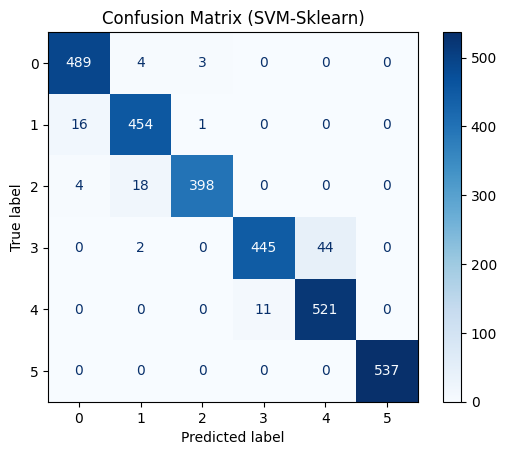

AUC Scores (per class): [0.99964712 0.99895987 0.99932727 0.9948702  0.99765485 1.        ]
Mean AUC: 0.9984


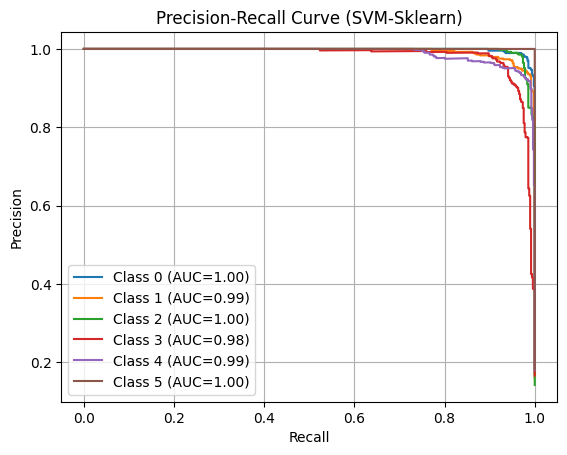

In [317]:
svm_best_params['probability'] = True
train_test_sklearn(X_train, y_train, X_test, y_test, SVC, svm_best_params, "SVM-Sklearn")

In [284]:
dt_params = {"max_depth": [5, 10, 15, 20], "min_samples_split": [5, 10, 15]}
dt_best_params = cross_validation_sklearn(X_train, y_train, DecisionTreeClassifier, param_grid=dt_params)

Hyperparameters: {'max_depth': 5, 'min_samples_split': 5}: Mean Validation Accuracy: 0.9038
Hyperparameters: {'max_depth': 5, 'min_samples_split': 10}: Mean Validation Accuracy: 0.9064
Hyperparameters: {'max_depth': 5, 'min_samples_split': 15}: Mean Validation Accuracy: 0.9018
Hyperparameters: {'max_depth': 10, 'min_samples_split': 5}: Mean Validation Accuracy: 0.9402
Hyperparameters: {'max_depth': 10, 'min_samples_split': 10}: Mean Validation Accuracy: 0.9433
Hyperparameters: {'max_depth': 10, 'min_samples_split': 15}: Mean Validation Accuracy: 0.9361
Hyperparameters: {'max_depth': 15, 'min_samples_split': 5}: Mean Validation Accuracy: 0.9399
Hyperparameters: {'max_depth': 15, 'min_samples_split': 10}: Mean Validation Accuracy: 0.9412
Hyperparameters: {'max_depth': 15, 'min_samples_split': 15}: Mean Validation Accuracy: 0.9423
Hyperparameters: {'max_depth': 20, 'min_samples_split': 5}: Mean Validation Accuracy: 0.9429
Hyperparameters: {'max_depth': 20, 'min_samples_split': 10}: Mean V

Accuracy on Test Set: 0.8713946386155412
              precision    recall  f1-score   support

           0     0.8430    0.9093    0.8749       496
           1     0.8378    0.7898    0.8131       471
           2     0.8799    0.8548    0.8671       420
           3     0.8627    0.7678    0.8125       491
           4     0.8055    0.8872    0.8444       532
           5     1.0000    1.0000    1.0000       537

    accuracy                         0.8714      2947
   macro avg     0.8715    0.8681    0.8687      2947
weighted avg     0.8725    0.8714    0.8708      2947



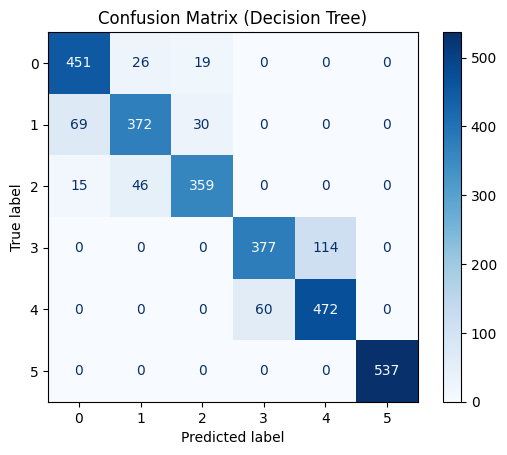

AUC Scores (per class): [0.95189505 0.87614346 0.92600722 0.91938774 0.93332244 1.        ]
Mean AUC: 0.9345


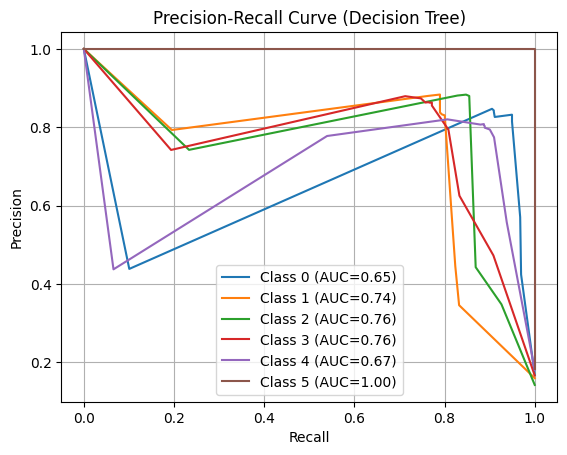

In [318]:
train_test_sklearn(X_train, y_train, X_test, y_test, DecisionTreeClassifier, dt_best_params, "Decision Tree")

In [295]:
knn_params = {"n_neighbors": [1, 2, 3, 4, 5]}
knn_best_params = cross_validation_sklearn(X_train, y_train, KNeighborsClassifier, param_grid=knn_params)

Hyperparameters: {'n_neighbors': 1}: Mean Validation Accuracy: 0.9672
Hyperparameters: {'n_neighbors': 2}: Mean Validation Accuracy: 0.9604
Hyperparameters: {'n_neighbors': 3}: Mean Validation Accuracy: 0.9690
Hyperparameters: {'n_neighbors': 4}: Mean Validation Accuracy: 0.9665
Hyperparameters: {'n_neighbors': 5}: Mean Validation Accuracy: 0.9656
Best Hyperparameters: {'n_neighbors': 3}, Best Validation Accuracy: 0.9690


Accuracy on Test Set: 0.8907363420427553
              precision    recall  f1-score   support

           0     0.8498    0.9698    0.9058       496
           1     0.8960    0.8960    0.8960       471
           2     0.9320    0.7833    0.8512       420
           3     0.8685    0.7800    0.8219       491
           4     0.8176    0.8929    0.8535       532
           5     1.0000    0.9963    0.9981       537

    accuracy                         0.8907      2947
   macro avg     0.8940    0.8864    0.8878      2947
weighted avg     0.8936    0.8907    0.8899      2947



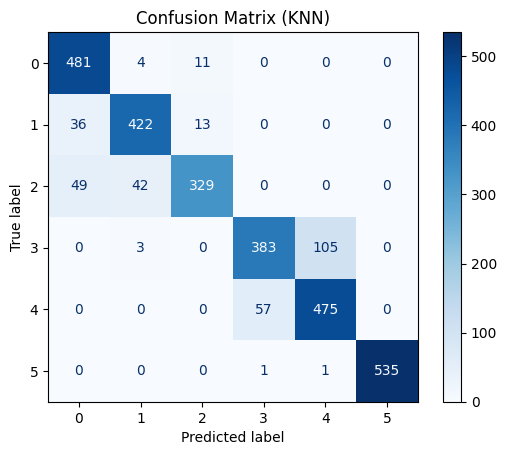

AUC Scores (per class): [0.98131482 0.97289049 0.93786016 0.94626112 0.97340401 0.99999845]
Mean AUC: 0.9686


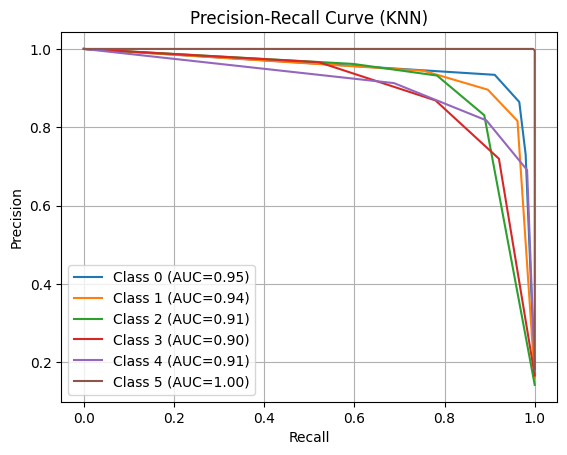

In [319]:
train_test_sklearn(X_train, y_train, X_test, y_test, KNeighborsClassifier, knn_best_params, "KNN")